In [1]:
# imports
from torch.utils.data import Dataset, DataLoader, IterableDataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch
import pandas as pd
import json
import torchvision.transforms as transforms
import random
import torch.nn as nn
import torchvision

Uncomment line to download and extract dataset

In [2]:
# !wget -P ./root "https://cloud.dfki.de/owncloud/index.php/s/TwrjNFYpTCEdeKB/download"
# !unzip ./root/download
# !tar -xvzf "./AAI WS2022/bens2.tar.gz"


Uncomment line to create environment and install required depenancies

In [3]:
# conda env create -f environment.yml


In [4]:

BigEarthNetlabels = {
    "Urban fabric": 0,
    "Industrial or commercial units": 1,
    "Arable land": 2,
    "Permanent crops": 3,
    "Pastures": 4,
    "Complex cultivation patterns": 5,
    "Land principally occupied by agriculture, with significant areas of natural vegetation": 6,
    "Agro-forestry areas": 7,
    "Broad-leaved forest": 8,
    "Coniferous forest": 9,
    "Mixed forest": 10,
    "Natural grassland and sparsely vegetated areas": 11,
    "Moors, heathland and sclerophyllous vegetation": 12,
    "Transitional woodland, shrub": 13,
    "Beaches, dunes, sands": 14,
    "Inland wetlands": 15,
    "Coastal wetlands": 16,
    "Inland waters": 17,
    "Marine waters": 18
}

BigEarthNetLabelNames = {v: k for k, v in BigEarthNetlabels.items()}


Create Training, Validation and Test data sets 

In [5]:
def getFilePath(dirName, fileName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_{}'.format(
        dirName, dirName, fileName)
    return path

# Merge RGB bands and return numpy image array


def getNumpyImageCv2(dirName):
    blue = cv2.imread(getFilePath(dirName, "B02.tif"),
                      cv2.IMREAD_UNCHANGED)
    blue = (blue-np.min(blue))/(np.max(blue)-np.min(blue))
    green = cv2.imread(getFilePath(
        dirName, "B03.tif"), cv2.IMREAD_UNCHANGED)
    green = (green-np.min(green))/(np.max(green)-np.min(green))
    red = cv2.imread(getFilePath(dirName, "B04.tif"),
                     cv2.IMREAD_UNCHANGED)
    red = (red-np.min(red))/(np.max(red)-np.min(red))
    return cv2.resize(cv2.merge([red, green, blue]), dsize=(224, 224))


def loadJson(dirName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_labels_metadata.json'.format(
        dirName, dirName)
    with open(getFilePath(dirName, "labels_metadata.json")) as json_data:
        return json.load(json_data)


fileList = os.listdir(path='./netscratch/siddamsetty/kosovo_files/')

valSplit = int(np.floor(0.2*len(fileList)))
testSplit = valSplit
trainSplit = len(fileList) - valSplit - testSplit
train_set, val_set, test_set = torch.utils.data.random_split(
    fileList, [trainSplit, valSplit, testSplit])


def save(name, datset):
    if not os.path.exists("./data/"+name):
        os.makedirs("./data/"+name)
    lablesList = np.zeros(shape=(len(datset), 20), dtype=np.object_)
    for index, dirName in enumerate(datset):
        image = getNumpyImageCv2(dirName)*255
        # print(np.shape(image))
        cv2.imwrite("./data/"+name+"/"+dirName+'.jpg', image)
        labelMetadata = loadJson(dirName)
        labels = labelMetadata.get('labels')
        lablesList[index, 0] = dirName
        for label in labels:
            if BigEarthNetlabels.get(label) is not None:
                lablesList[index, BigEarthNetlabels.get(label)+1] = 1
    np.savetxt("./data/"+name+'/labels.csv',
               lablesList, delimiter=",", fmt="%s")


uncomment below lines to generate dataset again

In [6]:
# save("train",train_set)
# save("val",val_set)
# save("test",test_set)


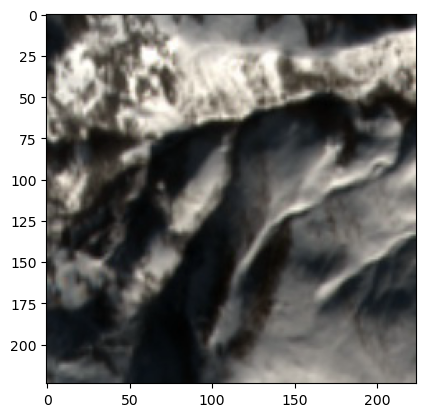

In [7]:
imageRead = cv2.imread("./data/test/S2A_MSIL2A_20171208T093351_0_22.jpg")
plt.imshow(imageRead)
plt.show()


Creating Dataset and Dataloader class for training

In [8]:
class BigEarthNetDataset(Dataset):

    def __init__(self, data_path, label_filename, transform=None, target_transform = None):
        self.fileList = os.listdir(path=data_path)
        labelPath = os.path.join(data_path, label_filename)
        self.img_labels = pd.read_csv(labelPath, header=None)
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.img_labels.index)

    def __getitem__(self, index):
        imagePath = os.path.join(self.data_path,"{}.jpg".format(self.img_labels.iloc[index, 0]))
        image = cv2.imread(imagePath)
        labels = self.img_labels.iloc[index, 1:].to_numpy(dtype=np.float32)
        if self.transform:
            image = self.transform(image.astype(np.float32))
        labels = torch.tensor(labels)
        return image, labels

    def getName(self, index):
        return self.img_labels.iloc[index, 0]


In [9]:
print("Initializing Datasets and Dataloaders...")

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valDataSet = BigEarthNetDataset(
    data_path='./data/val', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

trainDataSet = BigEarthNetDataset(
    data_path='./data/train', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

testDataSet = BigEarthNetDataset(
    data_path='./data/test', label_filename="labels.csv")   

dataloaders_dict = {"train": DataLoader(trainDataSet, batch_size=32, shuffle=True, num_workers=4), "val": DataLoader(
    valDataSet, batch_size=32, shuffle=True, num_workers=4), "test": DataLoader(testDataSet, batch_size=32, shuffle=True, num_workers=4)}


Initializing Datasets and Dataloaders...


Visualizing Random sample with labels

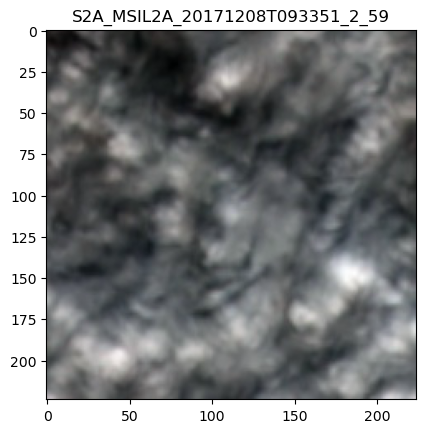

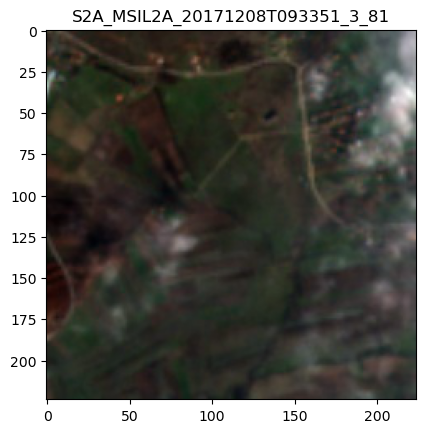

In [10]:

for index in random.sample(range(0, testDataSet.__len__()), 2):
    image, labels = testDataSet[index]
    plt.title(testDataSet.getName(index))
    plt.imshow(image)
    plt.show()

## todo: show lables along with image

In [11]:
device = torch.device("cpu")

In [12]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (19) and a Sigmoid instead of a default Softmax.


class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = torchvision.models.resnext50_32x4d(
            weights=torchvision.models.ResNeXt50_32X4D_Weights.DEFAULT)
        resnet.fc = torch.nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features,
                      out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))


# Initialize the model
model = Resnext50(len(BigEarthNetlabels))
# Switch model to the training mode
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [13]:
criterion = torch.nn.BCELoss()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.


def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [15]:
batch_size = 32
max_epoch_number = 13
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
import numpy as np
import torch


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='..//masters//save_model//checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_acc, model):

        score = val_acc
        print(f'score is {score} and val_loss is {val_acc}')
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation acc increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc


In [17]:
epoch = 0
iteration = 0
test_freq = 7
save_freq = 1

resultF1 = 0
early_stopping = EarlyStopping(verbose=True, path="checkpoint.pt")

while True:
    batch_losses = []
    for imgs, targets in dataloaders_dict.get("train"):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets)

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in dataloaders_dict.get("val"):
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(
                np.array(model_result), np.array(targets))
            resultF1 = result.get("macro/f1")
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(
        epoch, iteration, loss_value))
    early_stopping(resultF1, model)
    if early_stopping.early_stop:
        break
    epoch += 1
    if max_epoch_number < epoch:
        break


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is 

epoch: 0 iter:  0 test: micro f1: 0.580 macro f1: 0.109 samples f1: 0.574


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter:  7 test: micro f1: 0.719 macro f1: 0.116 samples f1: 0.641


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter: 14 test: micro f1: 0.714 macro f1: 0.118 samples f1: 0.634


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter: 21 test: micro f1: 0.719 macro f1: 0.140 samples f1: 0.645


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter: 28 test: micro f1: 0.684 macro f1: 0.127 samples f1: 0.593


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter: 35 test: micro f1: 0.627 macro f1: 0.119 samples f1: 0.527


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 0 iter: 42 test: micro f1: 0.684 macro f1: 0.149 samples f1: 0.596
epoch: 0 iter: 46 train: loss:0.162
score is 0.14899348610007765 and val_loss is 0.14899348610007765
Validation acc increased (0.000000 --> 0.148993).  Saving model ...


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 1 iter: 49 test: micro f1: 0.705 macro f1: 0.164 samples f1: 0.608


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 1 iter: 56 test: micro f1: 0.733 macro f1: 0.160 samples f1: 0.622


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 1 iter: 63 test: micro f1: 0.733 macro f1: 0.186 samples f1: 0.627


/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jaspreet/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/jaspreet/anaconda3

epoch: 1 iter: 70 test: micro f1: 0.645 macro f1: 0.155 samples f1: 0.582
